In [244]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from scipy.stats import pearsonr
from adjustText import adjust_text
from statannot import add_stat_annotation
from scipy.stats import ttest_1samp
import sys
import os
sys.path.append(os.path.abspath('../'))
from DE_analysis_utils import get_DE_results_long

In [10]:
datadir = '../../../../3_expts/processed_data'
adata_de = ad.read_h5ad(datadir + '/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed=False)
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
de_by_guide = pd.read_csv('./results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('./results/Stim8hr_debyguidegenes_donor_robustness_summary.csv', index_col=0)
de_donor_robustness = ad.read_h5ad(datadir + '/CD4i_final/CD4i_final.DE_donor_robustness.h5ad', backed=False)

In [219]:
target_gene_list = set(de_by_guide[(de_by_guide['culture_condition']=='Stim8hr')&(de_by_guide['correlation']>0.3)]['target'])
target_gene_list = target_gene_list & set(donor_robustness_summary[donor_robustness_summary['donor_correlation_min']>0.3]['target_name'])
target_gene_list = list(target_gene_list)
keep = (adata_de.obs['culture_condition']=='Stim8hr') & (adata_de.obs['target_contrast_gene_name'].isin(target_gene_list))
adata_de_filtered = adata_de[keep].to_memory()

In [220]:
gene1 = 'IL10'
gene2 = 'IL21'
# df_for_plot = pd.merge(get_DE_results_long(adata_de[adata_de.obs['culture_condition']=='Stim8hr'], genes=[gene1], effect_estimates=['log_fc', 'zscore'], signif_alpha=0.05),
#                        get_DE_results_long(adata_de[adata_de.obs['culture_condition']=='Stim8hr'], genes=[gene2], effect_estimates=['log_fc', 'zscore'], signif_alpha=0.05),
#                        on='target_contrast_gene_name',
#                        suffixes=['_'+gene1, '_'+gene2])
df_for_plot = pd.merge(get_DE_results_long(adata_de_filtered, genes=[gene1], effect_estimates=['log_fc', 'zscore'], signif_alpha=0.05),
                       get_DE_results_long(adata_de_filtered, genes=[gene2], effect_estimates=['log_fc', 'zscore'], signif_alpha=0.05),
                       on='target_contrast_gene_name',
                       suffixes=['_'+gene1, '_'+gene2])

In [351]:
followup_perts = ['MEN1', 'ELOB', 'SGF29', 'GATA3', 'STAT3', 'ATP2A2', 'CYB5R4', 'MED24', 'KDM1A', 'NFKB2', 'PPCS',]# 'FBRS']
color_perts = ['#fdae6b', '#fdae6b','#fdae6b', '#9ecae1', '#9ecae1', '#fa9fb5', '#8c96c6', '#6a51a3', '#ae017e', '#ae017e', '#ae017e',]# '#a1d99b']

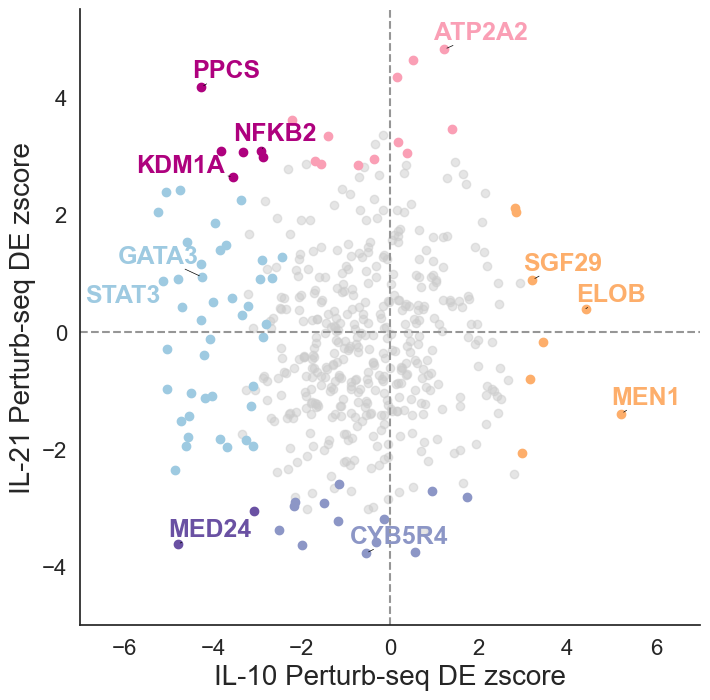

In [382]:
fig, ax = plt.subplots(figsize=(8,8))
# Non-significance
mask = ~df_for_plot['significant_'+gene1]&~df_for_plot['significant_'+gene2]
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#cccccc', alpha=0.5)
# Gene1 significant with zscore>0
mask = df_for_plot['significant_'+gene1]&~df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]>0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#fdae6b')
# Gene1 significant with zscore<0
mask = df_for_plot['significant_'+gene1]&~df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]<0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#9ecae1')
# Gene2 significant with zscore>0
mask = ~df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2] &(df_for_plot['zscore_'+gene2]>0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#fa9fb5')
# Gene2 significant with zscore<0
mask = ~df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2] &(df_for_plot['zscore_'+gene2]<0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#8c96c6')
# Both significant with zscore both <0
mask = df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]<0)&(df_for_plot['zscore_'+gene2]<0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#6a51a3')
# Both significant with gene1 zscore<0 gene2 zscore>0
mask = df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]<0)&(df_for_plot['zscore_'+gene2]>0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#ae017e')
ax.set_xlim([-7,7])
ax.set_ylim([-5,5.5])
ax.tick_params(labelsize=16)
ax.set_xlabel('IL-10 Perturb-seq DE zscore', fontsize=20)
ax.set_ylabel('IL-21 Perturb-seq DE zscore', fontsize=20)

# Labels
texts = []
for ind, pert in enumerate(followup_perts):
    texts.append(
        ax.text(df_for_plot.loc[df_for_plot['target_contrast_gene_name']==pert, 'zscore_'+gene1], df_for_plot.loc[df_for_plot['target_contrast_gene_name']==pert, 'zscore_'+gene2], pert,
                 fontsize=18, weight='bold', ha='center', va='bottom', color=color_perts[ind])
    )

# for _, row in df_for_plot[mask].iterrows():
#     texts.append(
#         plt.text(row['zscore_'+gene1], row['zscore_'+gene2], row['target_contrast_gene_name'],
#                  fontsize=10, weight='bold', ha='center', va='bottom')
#     )

# Adjust to avoid collisions
adjust_text(texts, x=df_for_plot['zscore_'+gene1], y=df_for_plot['zscore_'+gene2], arrowprops=dict(arrowstyle="-", color='black', lw=0.5), force_static=(0.5,0.5))

plt.axhline(0, linestyle='--', color='#969696')
plt.axvline(0, linestyle='--', color='#969696')

sns.despine()

plt.savefig('./results/IL10IL21_selected_regulators.png')

In [295]:
validation_df = pd.read_csv('../../../../3_expts/Cell_culture_experiments/Diff057andDiff060/IL10IL21FoldChange.csv')
validation_df['IL10_lfc'] = np.log(validation_df['IL10_fc'])
validation_df['IL21_lfc'] = np.log(validation_df['IL21_fc'])
results = []
for sg, group in validation_df.groupby('sgRNA'):
    t_stat, p_val = ttest_1samp(group['IL10_lfc'], 0)
    results.append({'sgRNA': sg, 'p_value_IL10': p_val})
results_df = pd.DataFrame(results)
validation_df = validation_df.merge(results_df, on='sgRNA')
results = []
for sg, group in validation_df.groupby('sgRNA'):
    t_stat, p_val = ttest_1samp(group['IL21_lfc'], 0)
    results.append({'sgRNA': sg, 'p_value_IL21': p_val})
results_df = pd.DataFrame(results)
validation_df = validation_df.merge(results_df, on='sgRNA')

In [342]:
validation_df

,Sample:,Donor,sgRNA,IL10_fc,IL21_fc,IL10_lfc,IL21_lfc,p_value_IL10,p_value_IL21
0,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_B...,Donor 3,GATA3,0.274306,0.560396,-1.293513,-0.579112,0.013342,0.620835
1,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_B...,Donor 3,MEN1,2.805556,0.288119,1.031602,-1.244382,0.004771,0.313105
2,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_C...,Donor 3,CYB5R4,0.555556,0.118812,-0.587787,-2.130214,0.013373,0.009111
3,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_C...,Donor 3,ELOB,3.854167,1.148515,1.349155,0.138470,0.009371,0.146435
4,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_C...,Donor 3,ATP2A2,0.892361,1.861386,-0.113884,0.621321,0.074924,0.024905
5,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_D...,Donor 4,GATA3,0.376518,1.946154,-0.976789,0.665855,0.013342,0.620835
6,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_D...,Donor 4,MEN1,3.748988,1.792308,1.321486,0.583504,0.004771,0.313105
7,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_E...,Donor 4,CYB5R4,0.570850,0.294872,-0.560628,-1.221215,0.013373,0.009111
8,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_E...,Donor 4,ELOB,2.028340,1.343590,0.707218,0.295345,0.009371,0.146435
9,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_E...,Donor 4,ATP2A2,0.603239,3.641026,-0.505442,1.292265,0.074924,0.024905


/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1960/3311692252.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(validation_df, x='sgRNA', y='IL10_lfc', ax=ax[0], order=['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'], palette=['#9ecae1', '#fdae6b', '#fdae6b', '#8c96c6', '#fa9fb5'])
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1960/3311692252.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(validation_df, x='sgRNA', y='IL21_lfc', ax=ax[1], order=['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'], palette=['#9ecae1', '#fdae6b', '#fdae6b', '#8c96c6', '#fa9fb5'])


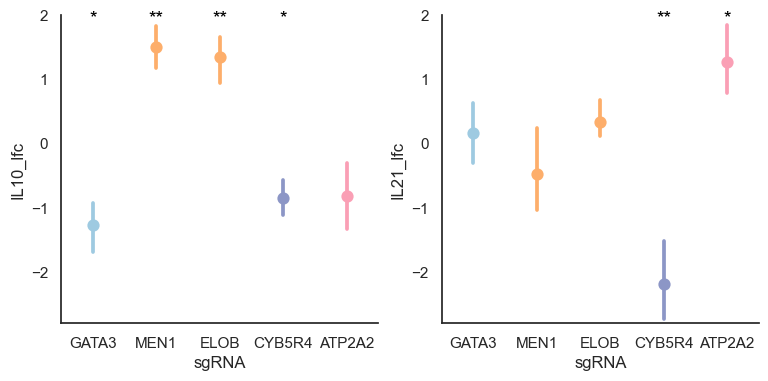

In [354]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.pointplot(validation_df, x='sgRNA', y='IL10_lfc', ax=ax[0], order=['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'], palette=['#9ecae1', '#fdae6b', '#fdae6b', '#8c96c6', '#fa9fb5'])

x_coords = np.linspace(0,4,5)
y_coords = pd.DataFrame(validation_df.groupby('sgRNA')['IL10_lfc'].mean()).loc[['GATA3','MEN1','ELOB','CYB5R4','ATP2A2']].values[:,0]

for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    sg = ['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'][i]
    p = validation_df.loc[validation_df['sgRNA'] == sg, 'p_value_IL10'].values[0]
    if p < 0.001:
        star = '***'
    elif p < 0.01:
        star = '**'
    elif p < 0.05:
        star = '*'
    else:
        star = ''
    if star:
        ax[0].text(x, 1.8, star, ha='center', va=va, fontsize=14, color='black')

sns.pointplot(validation_df, x='sgRNA', y='IL21_lfc', ax=ax[1], order=['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'], palette=['#9ecae1', '#fdae6b', '#fdae6b', '#8c96c6', '#fa9fb5'])

x_coords = np.linspace(0,4,5)
y_coords = pd.DataFrame(validation_df.groupby('sgRNA')['IL21_lfc'].mean()).loc[['GATA3','MEN1','ELOB','CYB5R4','ATP2A2']].values[:,0]

for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    sg = ['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'][i]
    p = validation_df.loc[validation_df['sgRNA'] == sg, 'p_value_IL21'].values[0]
    if p < 0.001:
        star = '***'
    elif p < 0.01:
        star = '**'
    elif p < 0.05:
        star = '*'
    else:
        star = ''
    if star:
        ax[1].text(x, 1.8, star, ha='center', va=va, fontsize=14, color='black')

ax[0].set_ylim([-2.8,2])
ax[1].set_ylim([-2.8,2])

sns.despine()
plt.savefig('./results/IL10IL21_validation.png')

<Axes: xlabel='sgRNA', ylabel='IL21_lfc'>

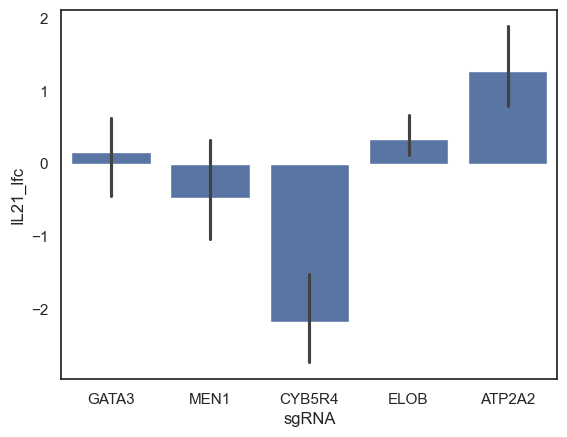

In [239]:
sns.barplot(validation_df, x='sgRNA', y='IL21_lfc')

In [3]:
de_donor_robustness.layers['zscore'] = de_donor_robustness.layers['log_fc'] / de_donor_robustness.layers['lfcSE']
de_donor_robustness.layers['zscore'][np.where(de_donor_robustness.layers['zscore'] > 50)] = 50
de_donor_robustness.X = np.nan_to_num(de_donor_robustness.layers['zscore'], 0)

In [12]:
de_donor_robustness = de_donor_robustness[de_donor_robustness.obs.culture_condition=='Stim8hr'].copy()

In [13]:
reg_all = ['MEN1', 'ELOB', 'FBRS', 'SGF29', 'ATP2A2', 'MED24', 'GATA3', 'CYB5R4', 'STAT3', 'APC', 'NFKB2', 'ATXN7L3', 'ELP2', 'PPCS', 'CCNC']
gene = ['IL22']

In [14]:
donor_pairs = de_donor_robustness.obs['donor_pair'].unique()

In [15]:
df_reg_gene = pd.DataFrame()
for donor_pair in donor_pairs:
    temp_df = get_DE_results_long(de_donor_robustness[de_donor_robustness.obs['donor_pair']==donor_pair], targets=de_donor_robustness.obs['target_contrast_gene_name'].tolist(), genes = gene)
    temp_df['donor_pair'] = donor_pair
    df_reg_gene = pd.concat([df_reg_gene, temp_df])
df_reg_gene = df_reg_gene.reset_index(drop=True)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_66609/1968415089.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt.plot(np.sort(df_reg_gene.groupby('target_contrast_gene_name')['zscore'].std()/df_reg_gene.groupby('target_contrast_gene_name')['zscore'].mean()), '.')


(-10.0, 10.0)

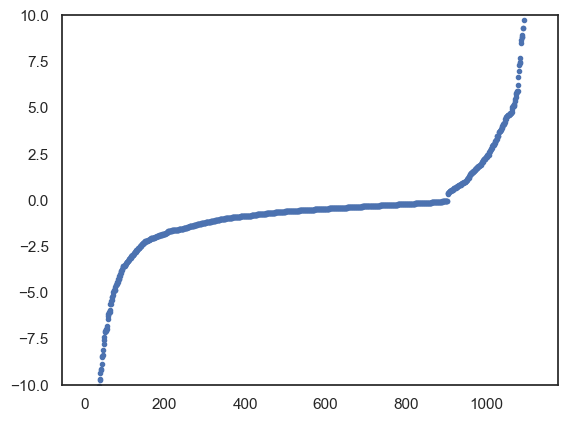

In [16]:
plt.plot(np.sort(df_reg_gene.groupby('target_contrast_gene_name')['zscore'].std()/df_reg_gene.groupby('target_contrast_gene_name')['zscore'].mean()), '.')
plt.ylim([-10,10])

### Set coefficient of variation < 1

In [24]:
reg = 'HNRNPA2B1'
df_reg_gene[df_reg_gene['target_contrast_gene_name']==reg].zscore.std()/df_reg_gene[df_reg_gene['target_contrast_gene_name']==reg].zscore.mean()

1.7479350214951164

In [69]:
target_gene_list = set(de_by_guide[(de_by_guide['culture_condition']=='Stim8hr')&(de_by_guide['correlation']>0.2)]['target'])
target_gene_list = target_gene_list & set(donor_robustness_summary[donor_robustness_summary['donor_correlation_min']>0.1]['target_name'])
target_gene_list = list(target_gene_list)

In [86]:
keep = (adata_de.obs['culture_condition']=='Stim8hr')# & (adata_de.obs['target_contrast_gene_name'].isin(target_gene_list))
adata_de_filtered = adata_de[keep].to_memory()
#adata_de_filtered = adata_de.to_memory()

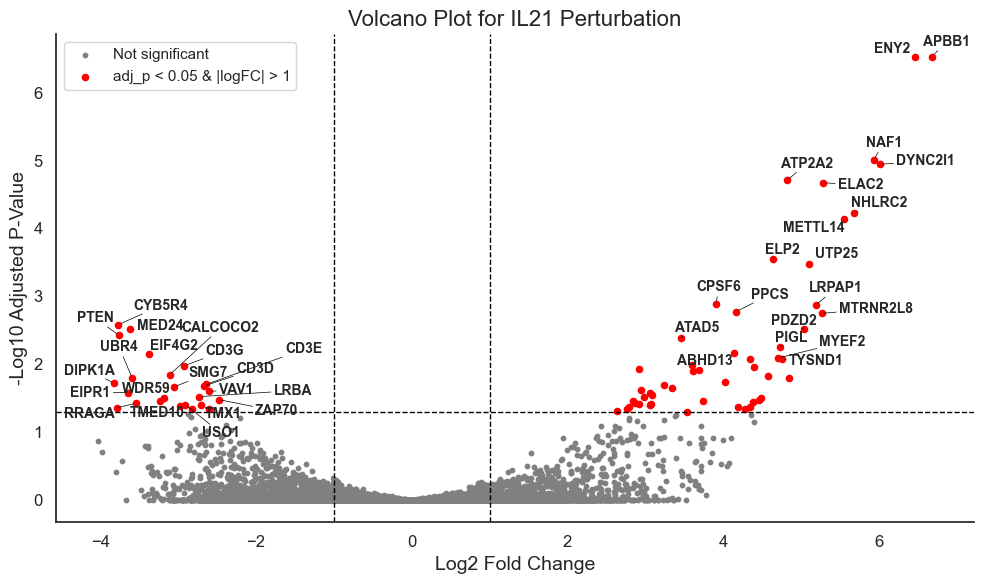

In [87]:
target_gene = 'IL21'
adj_p_thres = 0.05
log_fc_thres = 1

target_idx = np.where(adata_de_filtered.var['gene_name'] == target_gene)[0][0]
log_fc = adata_de_filtered[:, target_idx].layers['zscore'][:, 0]
adj_pvals = adata_de_filtered[:, target_idx].layers['adj_p_value'][:, 0]

log_fc = log_fc.toarray().flatten()
adj_pvals = adj_pvals.toarray().flatten()
gene_names = adata_de_filtered.obs.loc[:, 'target_contrast_gene_name_corrected'].values
neg_log10_pval = -np.log10(np.clip(adj_pvals, 1e-300, 1))

# Step 4: Significance mask
is_signif = (adj_pvals < adj_p_thres) & (np.abs(log_fc) > log_fc_thres)
sig_log_fc = log_fc[is_signif]
sig_pval = adj_pvals[is_signif]
sig_names = gene_names[is_signif]
sig_neglogp = neg_log10_pval[is_signif]

# Step 5: Get top N significant genes
top_n = 20
left_mask = sig_log_fc < 0
left_idx = np.argsort(-sig_neglogp[left_mask])[:top_n]
left_genes = sig_names[left_mask][left_idx]
right_mask = sig_log_fc > 0
right_idx = np.argsort(-sig_neglogp[right_mask])[:top_n]
right_genes = sig_names[right_mask][right_idx]
annot_genes = np.concatenate([left_genes, right_genes])

# Step 6: Plot
sns.set(style="white")
plt.figure(figsize=(10, 6))
plt.scatter(log_fc, neg_log10_pval, c='grey', s=10, label='Not significant')
plt.scatter(log_fc[is_signif], neg_log10_pval[is_signif], c='red', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')

# Labels
texts = []
for gene in annot_genes:
    idx = np.where(sig_names == gene)[0][0]
    texts.append(
        plt.text(sig_log_fc[idx], sig_neglogp[idx], gene,
                 fontsize=10, weight='bold', ha='center', va='bottom')
    )

# Adjust to avoid collisions
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Reference lines
plt.axvline(-log_fc_thres, color='black', linestyle='--', linewidth=1)
plt.axvline(log_fc_thres, color='black', linestyle='--', linewidth=1)
plt.axhline(-np.log10(adj_p_thres), color='black', linestyle='--', linewidth=1)

# Labels and formatting
plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=14)
plt.title(f'Volcano Plot for {target_gene} Perturbation', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [28]:
annot_genes = ['MEN1', 'ELOB', 'FBRS', 'SGF29', 'ATP2A2', 'MED24', 'GATA3', 'CYB5R4', 'STAT3'] # 'ATXN7L3', 'ELP2', 'PPCS']

In [92]:
summary_df.loc[['TBX21','GATA3','CFAP298','SORL1','PTPN2','POLE3','MEN1',
                'ARRDC4','CYB5R4','SFXN1','ELOB','ZNF74','ATP2A2','CCNC','TMED9'], 'IFNG_flowlfc'] = np.log([0.236682951,1.115685095,0.707111303,
                                                                                                             0.808116441,1.340527288,1.066418252,
                                                                                                             1.625631301,1.35879521,0.330350345,
                                                                                                             0.829940691,1.253849169,0.877373787,
                                                                                                             1.049694857,1.373313557,1.652605838])

In [93]:
annotations = summary_df[['zscore_IFNG', 'IFNG_flowlfc']].astype(str)
for i in range(len(df)):
    if summary_df['padj_IFNG'].iloc[i] < 0.05:
        annotations.iloc[i, 0] = f"{summary_df['padj_IFNG'].iloc[i]:.2e}"
        annotations.iloc[i, 1] = f""
    else:
        annotations.iloc[i, 0] = f""
        annotations.iloc[i, 1] = f""

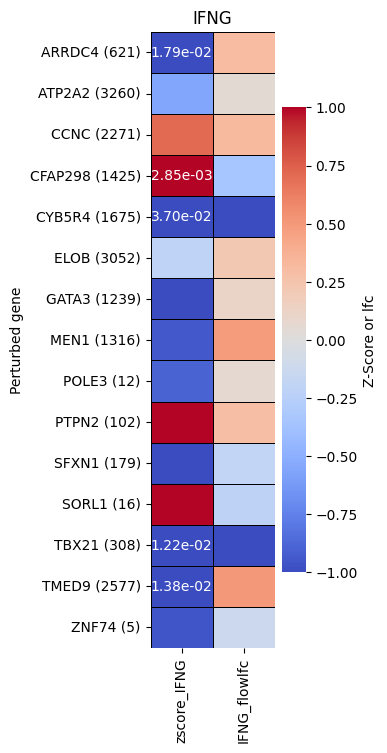

In [95]:
# Plot the heatmap
plt.figure(figsize=(2, 8))
sns.heatmap(
    summary_df[['zscore_IFNG', 'IFNG_flowlfc']],
    annot=annotations,
    fmt="",
    cmap='coolwarm',
    cbar_kws={'label': 'Z-Score or lfc'},
    linewidths=0.5,
    linecolor='black',
    yticklabels=[gene+f' ({nde})' for gene, nde in zip(summary_df.index,summary_df.n_total_de_genes)],
    vmin=-1,
    vmax=1
)
plt.title('IFNG')
plt.ylabel('Perturbed gene')
plt.yticks(rotation=0)
plt.show()

### Pick state regulators

In [108]:
polarization_coefficient = pd.read_csv('../4_polarization_signatures/results/polarization_prediction_condition_comparison.regulator_coefficients.csv', index_col=0)

In [133]:
test = polarization_coefficient[(polarization_coefficient['signature']=='ota')&(polarization_coefficient['celltype']=='Stim8hr')].copy()

In [132]:
de_by_guide

,target,correlation,correlation_ceiling,n_signif,culture_condition
0,A2M,-0.466086,NaN,10,Rest
1,ABCC1,0.084480,NaN,84,Rest
2,ABHD12,0.490760,0.628502,360,Rest
3,ABHD13,-0.301527,0.527995,507,Rest
4,ABHD14A,0.958795,0.943289,5,Rest
...,...,...,...,...,...
3047,ZNF76,0.517532,0.923784,25,Stim48hr
3048,ZNF829,0.628259,0.886746,52,Stim48hr
3049,ZNF837,0.565384,0.863103,83,Stim48hr
3050,ZNF92,0.053507,0.518101,124,Stim48hr


In [ ]:
['JAK2', 'KDM1A', 'EHMT2', 'SEC22A', 'PSMF1', 'NAB2', 'RELL2', 'PCNX3']

In [134]:
test = pd.merge(test, de_by_guide[de_by_guide.culture_condition=='Stim8hr'][de_by_guide.columns[[0,1,2]]], how='outer', left_on='regulator', right_on='target')
test = pd.merge(test, donor_robustness_summary[donor_robustness_summary.columns[[0,1,2,5,8,9,11]]], how='outer', left_on='regulator', right_on='target_name')

In [137]:
test.sort_values(by='coef_rank').head(50)

,coef_mean,coef_sem,coef_rank,regulator,known_regulators,dataset_key,regulator_type,celltype,signature,target,correlation,correlation_ceiling,target_name,donor_correlation_mean,donor_correlation_min,n_cells_target,n_total_de_genes,ontarget_effect_size,baseMean
1570,0.039699,0.001221,0.000000,IRF1,True,ota_Stim8hr,Th1 regulator,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1600,0.038800,0.001061,0.000255,JAK2,True,ota_Stim8hr,Th1 regulator,Stim8hr,ota,JAK2,0.511745,0.929815,JAK2,0.456968,0.338179,815.0,34.0,-21.889337,169.639430
3305,0.037595,0.001554,0.000509,THAP2,False,ota_Stim8hr,NaN,Stim8hr,ota,THAP2,0.430240,0.720459,THAP2,0.076253,-0.037856,505.0,170.0,-5.753547,14.291639
2316,0.036772,0.001382,0.000764,PAN2,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1503,0.034565,0.000755,0.001019,IFNGR1,True,ota_Stim8hr,Th1 regulator,Stim8hr,ota,IFNGR1,0.849033,0.940924,IFNGR1,0.668595,0.520008,412.0,110.0,-9.173010,28.798655
1504,0.031142,0.000804,0.001274,IFNGR2,True,ota_Stim8hr,Th1 regulator,Stim8hr,ota,IFNGR2,0.936616,0.833186,IFNGR2,0.475312,0.059789,510.0,70.0,-4.715141,7.535592
1015,0.030585,0.000795,0.001528,ENKUR,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1627,0.030306,0.001099,0.001783,KDM1A,False,ota_Stim8hr,NaN,Stim8hr,ota,KDM1A,0.844114,0.848962,KDM1A,0.732691,0.700852,541.0,2301.0,-21.050217,106.643849
1239,0.030229,0.000748,0.002038,GCSAM,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3044,0.030194,0.000963,0.002292,SMAGP,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
